In [39]:
import math
import keras
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

from google.colab import files

plt.style.use('default')

In [2]:
market = 'BTC-GBP'
granularity = 3600

In [3]:
def getHistoricalData(market: str='BTC-GBP', granularity: int=3600, iso8601start: str='', iso8601end: str='') -> pd.DataFrame:
  if iso8601start != '' and iso8601end == '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}')
  elif iso8601start != '' and iso8601end != '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}&end={iso8601end}')
  else:
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}')

  df = pd.DataFrame.from_dict(resp.json())
  df.columns = [ 'epoch','low','high','open','close','volume' ]
  df['adj_close'] = df['close']

  tsidx = pd.DatetimeIndex(pd.to_datetime(df['epoch'], unit='s'), dtype='datetime64[ns]')
  df.set_index(tsidx, inplace=True)
  df = df.drop(columns=['epoch'])
  df.index.names = ['date']

  return df.iloc[::-1].reset_index()

In [4]:
def getHistoricalDataChained(market: str='BTC-GBP', granularity: int=3600, max_interations: int=1) -> pd.DataFrame:
  df1 = getHistoricalData(market, granularity)

  if max_interations == 1:
    return df1

  def getPreviousDateRange(df: pd.DataFrame=None) -> tuple:
    end_date = df['date'].min() - timedelta(seconds=(granularity/60))
    new_start = df['date'].min() - timedelta(hours=300*(granularity/60/60))
    return (str(new_start).replace(' ', 'T'), str(end_date).replace(' ', 'T'))

  iterations = 0
  result_df = pd.DataFrame()
  while iterations < (max_interations - 1):
    start_date, end_date = getPreviousDateRange(df1)
    df2 = getHistoricalData(market, granularity, start_date, end_date)
    result_df = pd.concat([df2, df1]).drop_duplicates()
    df1 = result_df
    iterations = iterations + 1

  if 'date'in result_df:
    result_df.sort_values(by=['date'], ascending=True, inplace=True)
        
  return result_df

In [5]:
iterations = math.ceil((525600/(granularity/60))/300) # minutes in a year divided by 300 data size
df = getHistoricalDataChained(market, granularity, iterations)
iterations, df.shape, df['date'].min(), df['date'].max()

(30,
 (8998, 7),
 Timestamp('2020-06-11 10:00:00'),
 Timestamp('2021-06-21 09:00:00'))

In [6]:
df.head()

,date,low,high,open,close,volume,adj_close
0,2020-06-11 10:00:00,7703.83,7744.50,7729.54,7744.50,35.301015,7744.50
1,2020-06-11 11:00:00,7716.21,7749.00,7740.22,7747.84,67.979470,7747.84
2,2020-06-11 12:00:00,7675.00,7758.00,7746.96,7696.29,73.166814,7696.29
3,2020-06-11 13:00:00,7611.00,7712.81,7689.53,7633.97,137.447861,7633.97
4,2020-06-11 14:00:00,7613.19,7650.30,7631.61,7623.22,81.942937,7623.22


In [7]:
X = df[['low','high','open','close','volume']]
#X = df[['close']]
y = df[['close']]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, stratify=None)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6748, 5), (2250, 5), (6748, 1), (2250, 1))

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1)) # normalise rows
training_set_scaled = scaler.fit_transform(X_train)

if granularity == 60:
  window = 1440 # num minutes in 1 day
elif granularity == 300:
  window = 288 # num 5 minutes in 1 day
elif granularity == 900:
  window = 94 # num 15 minutes in 1 day
elif granularity == 3600:
  window = 24 # num hours in 1 day
elif granularity == 21600:
  window = 4 # num 6 hours in 1 day
else:
  window = 1 # 1 day

X_train_window=[]
y_train_window=[]
for i in range(window, len(X_train)):
  X_train_window.append(training_set_scaled[i-window:i, 0])
  y_train_window.append(training_set_scaled[i, 0])

X_train_window, y_train_window = np.array(X_train_window), np.array(y_train_window)
X_train_window = np.reshape(X_train_window, (X_train_window.shape[0], X_train_window.shape[1], 1))

X_train_window.shape, y_train_window.shape

((6724, 24, 1), (6724,))

In [9]:
def create_model():
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_window.shape[1], 1))) # layer 1 lstm
  model.add(Dropout(0.2)) # layer 1 dropout regularisation
  model.add(LSTM(units=50, return_sequences=True)) # layer 2 lstm
  model.add(Dropout(0.2)) # layer 2 dropout regularisation
  model.add(LSTM(units=50, return_sequences=True)) # layer 3 lstm
  model.add(Dropout(0.2)) # layer 3 dropout regularisation
  model.add(LSTM(units=50)) # layer 4 lstm
  model.add(Dropout(0.2)) # layer 4 dropout regularisation
  model.add(Dense(units=1)) # output layer
  model.compile(optimizer='adam', loss='mean_squared_error') # compile the rnn 
  return model

model = create_model()
model.fit(X_train_window, y_train_window, epochs=100, batch_size=32, verbose=2)
model.summary()

Epoch 1/100
211/211 - 27s - loss: 0.0041
Epoch 2/100
211/211 - 2s - loss: 0.0017
Epoch 3/100
211/211 - 2s - loss: 0.0016
Epoch 4/100
211/211 - 2s - loss: 0.0014
Epoch 5/100
211/211 - 2s - loss: 0.0013
Epoch 6/100
211/211 - 2s - loss: 0.0012
Epoch 7/100
211/211 - 2s - loss: 0.0011
Epoch 8/100
211/211 - 2s - loss: 0.0010
Epoch 9/100
211/211 - 2s - loss: 0.0010
Epoch 10/100
211/211 - 2s - loss: 9.7999e-04
Epoch 11/100
211/211 - 2s - loss: 9.6923e-04
Epoch 12/100
211/211 - 2s - loss: 0.0012
Epoch 13/100
211/211 - 2s - loss: 9.4509e-04
Epoch 14/100
211/211 - 2s - loss: 9.0148e-04
Epoch 15/100
211/211 - 2s - loss: 9.0388e-04
Epoch 16/100
211/211 - 2s - loss: 8.1677e-04
Epoch 17/100
211/211 - 2s - loss: 8.5707e-04
Epoch 18/100
211/211 - 2s - loss: 9.2080e-04
Epoch 19/100
211/211 - 2s - loss: 8.1379e-04
Epoch 20/100
211/211 - 2s - loss: 9.6046e-04
Epoch 21/100
211/211 - 2s - loss: 7.9754e-04
Epoch 22/100
211/211 - 2s - loss: 8.6074e-04
Epoch 23/100
211/211 - 2s - loss: 7.4772e-04
Epoch 24/100


In [40]:
'''Optionally save model, model.json and weights.h5'''

model_filename = f'model_{market}_{granularity}_{len(X_train.columns)}-inputs.json'
weights_filename = f'weights_{market}_{granularity}_{len(X_train.columns)}-inputs.h5'

!ls /content

# save structure to json
model_json = model.to_json()
with open(model_filename, 'w') as json_file:
  json_file.write(model_json)

# save weights to hdf5
model.save_weights(weights_filename)

files.download(f'/content/{model_filename}')
files.download(f'/content/{weights_filename}')

model_BTC-GBP_3600_5-inputs.json  sample_data  weights_BTC-GBP_3600_5-inputs.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
'''Optionally load model, model.json and weights.h5'''

model_filename = f'model_{market}_{granularity}_{len(X_train.columns)}-inputs.json'
weights_filename = f'weights_{market}_{granularity}_{len(X_train.columns)}-inputs.h5'

try:
  files.upload()
  !ls /content

  # read structure from json
  model = open(model_filename, 'r')
  json = model.read()
  model.close()
  model = model_from_json(json)

  # read weights from hdf5
  model.load_weights(f'/content/{weights_filename}')
except Exception as e:
  print (e)

Saving model_BTC-GBP_3600_5-inputs.json to model_BTC-GBP_3600_5-inputs (2).json
Saving weights_BTC-GBP_3600_5-inputs.h5 to weights_BTC-GBP_3600_5-inputs (1).h5
'model_BTC-GBP_3600_5-inputs (1).json'	 sample_data
'model_BTC-GBP_3600_5-inputs (2).json'	'weights_BTC-GBP_3600_5-inputs (1).h5'
 model_BTC-GBP_3600_5-inputs.json	 weights_BTC-GBP_3600_5-inputs.h5


In [44]:
df_y_train = y.iloc[:len(X_train)]
df_y_test = y.iloc[len(X_train):]
df_y = pd.concat((df_y_train, df_y_test), axis=0)

scaler_y = MinMaxScaler(feature_range=(0, 1))
test_set_scaled = scaler_y.fit_transform(df_y)

inputs = df_y[len(df_y)-len(df_y_test)-window:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler_y.transform(inputs)

X_test_window = []
for i in range(window, len(y_test)+window):
  X_test_window.append(inputs[i-window:i, 0])

X_test_window = np.array(X_test_window)
X_test_window = np.reshape(X_test_window, (X_test_window.shape[0], X_test_window.shape[1], 1))

print ('inputs.shape', inputs.shape, 'X_test_window.shape', X_test_window.shape)

y_pred = model.predict(X_test_window)
y_pred = scaler_y.inverse_transform(y_pred)

print ('X_test.shape', X_test.shape, 'y_pred.shape', y_pred.shape)

inputs.shape (2274, 1) X_test_window.shape (2250, 24, 1)
X_test.shape (2250, 5) y_pred.shape (2250, 1)


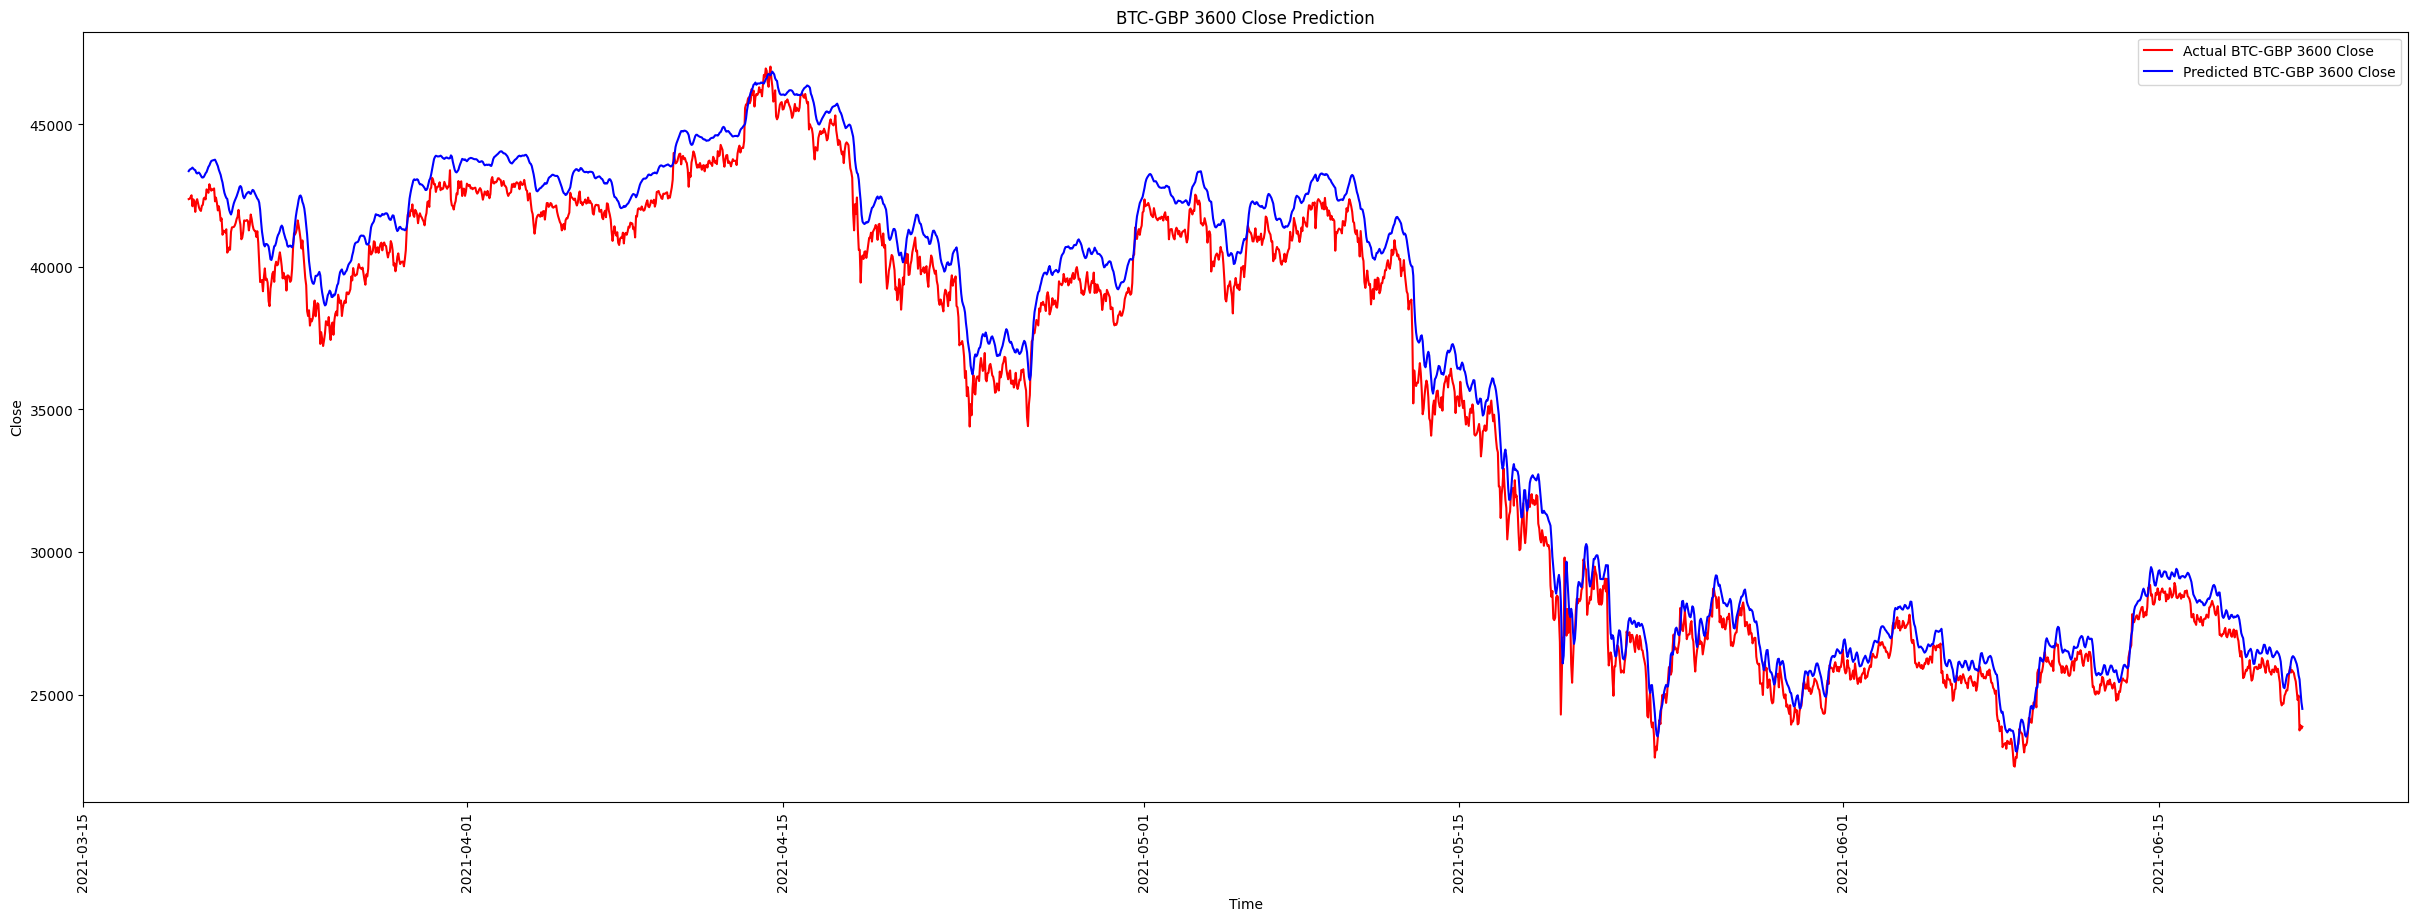

In [45]:
plt.figure(figsize=(30,10))
plt.plot(df[len(X_train):]['date'], df_y_test, color='red', label=f'Actual {market} {granularity} {y.columns.values[0].capitalize()}')
plt.plot(df[len(X_train):]['date'], y_pred, color='blue', label=f'Predicted {market} {granularity} {y.columns.values[0].capitalize()}')
plt.title(f'{market} {granularity} {y.columns.values[0].capitalize()} Prediction')
plt.xlabel('Time')
plt.ylabel(f'{y.columns.values[0].capitalize()}')
plt.xticks(rotation=90)
plt.legend()
plt.show()